# Multiplexed smFISH data SSAM analysis

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
import pickle
import numpy as np
import pandas as pd

from shapely.geometry import Point, Polygon

In [17]:
plt.rcParams["font.family"] = "Arial"

In [18]:
cell_class_colors = {
    "Lamp5": "#DA808C",
    "Sncg": "#D633FF",
    "Serpinf1": "#8510C0",
    "Vip": "#B864CC",
    "Sst": "#FF9900",
    "Pvalb": "#D93137",
    "L2/3 IT": "#C4EC04",
    "L4": "#00979D",
    "L5 IT": "#50B2AD",
    "L6 IT": "#A19922",
    "L5 PT": "#0D5B78",
    "L5 NP": "#3E9E64",
    "L6 CT": "#69A8E6",
    "L6 PT": "#2D8CB8",
    "L6b": "#53377D",
    "Meis2": "#FF0000",
    "CR": "#00FF66",
    "Astro": "#665C47",
    "Oligo": "#2E3E39",
    "VLMC": "#697255",
    "Peri": "#665547",
    "SMC": "#807059",
    "Endo": "#8D6C62",
    "Macrophage": "#537358",
}

In [19]:
seg_df = pd.read_csv("data/baysor/allen_smfish/segmentation.csv")

In [20]:
import pandas as pd
spots = pd.read_csv("data/raw/smFISH_MCT_CZI_Panel_0_spot_table.csv", usecols=["x", "y", "target"]).rename(columns={"target": "gene"}).set_index('gene')
spots['cell'] = seg_df['cell'].to_numpy()
um_per_pixel = 0.1
spots.x = spots.x*um_per_pixel
spots.y = spots.y*um_per_pixel
spots.x -= spots.x.min()
spots.y -= spots.y.min()

In [21]:
import json
with open("spacejam2/data/annotations/Allen_smFISH_annotations_geo.json") as f:
    annotations = json.load(f)['geometries'][0]
p = Polygon(annotations["coordinates"][0])
spots['layers'] = ["VISp" if p.intersects(Point(a)) else "outside_VISp" for a in spots[["x","y"]].values]

In [22]:
spots = pd.DataFrame(spots[spots['layers'] == 'VISp'])

In [23]:
import numpy as np

In [24]:
beta = 3.65568224985292
rotm = np.array([[np.cos(beta), np.sin(beta)], [-np.sin(beta), np.cos(beta)]])
pos_um = np.array([spots.x, spots.y])
rot_um = np.dot(pos_um.T, rotm)
rot_um[:, 0] -= np.min(rot_um[:, 0])
rot_um[:, 1] -= np.min(rot_um[:, 1])

In [25]:
spots.x = rot_um[:, 0]
spots.y = rot_um[:, 1]

In [11]:
spots

,x,y,cell,layers
gene,,,,
Fezf2,1315.182205,819.217163,1605,VISp
Fezf2,1320.888600,849.389891,2496,VISp
Fezf2,1312.216275,828.169190,1605,VISp
Fezf2,1326.185386,826.385356,1041,VISp
Fezf2,1311.445646,830.360813,1605,VISp
...,...,...,...,...
Parm1,138.048814,405.155912,2822,VISp
Parm1,134.461634,507.451830,407,VISp
Parm1,152.472339,434.736509,4354,VISp


In [4]:
import ssam

In [5]:
ds = ssam.SSAMDataset("ssam_data/msmfish")
analysis = ssam.SSAMAnalysis(ds, ncores=10, verbose=True)

In [62]:
width = int(spots.x.max())
height = int(spots.y.max())
analysis.run_kde(locations=spots, width=width, height=height, bandwidth=2.5)

Running KDE for gene Alcam...
Saving KDE for gene Alcam...
Running KDE for gene Chodl...
Saving KDE for gene Chodl...
Running KDE for gene Cux2...
Saving KDE for gene Cux2...
Running KDE for gene Fezf2...
Saving KDE for gene Fezf2...
Running KDE for gene Foxp2...
Saving KDE for gene Foxp2...
Running KDE for gene Gad2...
Saving KDE for gene Gad2...
Running KDE for gene Galnt14...
Saving KDE for gene Galnt14...
Running KDE for gene Grin3a...
Saving KDE for gene Grin3a...
Running KDE for gene Kcnip4...
Saving KDE for gene Kcnip4...
Running KDE for gene Kcnk2...
Saving KDE for gene Kcnk2...
Running KDE for gene Lhx6...
Saving KDE for gene Lhx6...
Running KDE for gene Mpped1...
Saving KDE for gene Mpped1...
Running KDE for gene Parm1...
Saving KDE for gene Parm1...
Running KDE for gene Pde1a...
Saving KDE for gene Pde1a...
Running KDE for gene Prox1...
Saving KDE for gene Prox1...
Running KDE for gene Pvalb...
Saving KDE for gene Pvalb...
Running KDE for gene Rorb...
Saving KDE for gene Ror

In [6]:
analysis.load_kde()

In [18]:
exp_thres = 0.027
norm_thres = 0.2

In [19]:
analysis.find_localmax(search_size=3)

Found 5081 local max vectors.


In [20]:
analysis.normalize_vectors()

Loaded a cached normalized vector field (to avoid this behavior, set re_run=True).


In [7]:
cell_by_gene = pd.read_csv("data/jeremy_filtered/smFISH_filtered_cellxgene.csv")
cell_by_gene = cell_by_gene.set_index('gene_name').T[ds.genes]

In [8]:
cell_by_gene

gene_name,Alcam,Chodl,Cux2,Fezf2,Foxp2,Gad2,Galnt14,Grin3a,Kcnip4,Kcnk2,...,Parm1,Pde1a,Prox1,Pvalb,Rorb,Satb2,Sema3e,Sez6,Sv2c,Thsd7a
1,0,0,0,15,20,0,0,1,0,30,...,0,16,0,1,0,9,4,12,0,0
5,4,1,20,3,1,3,2,0,1,39,...,1,10,2,3,52,32,2,6,1,2
6,36,1,39,1,1,0,1,0,2,3,...,0,6,1,1,2,24,1,6,1,1
7,32,1,37,2,1,0,0,1,1,8,...,2,20,1,2,2,18,2,7,0,1
9,66,0,19,2,0,75,0,0,0,6,...,6,1,0,255,7,1,1,3,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4664,19,1,42,2,2,1,0,0,1,3,...,1,32,1,0,2,13,0,19,0,2
4665,0,0,0,15,21,1,0,0,0,32,...,0,39,0,3,0,11,15,28,0,0
4669,57,10,6,9,5,65,23,50,4,18,...,6,4,4,6,2,4,20,8,7,6
4670,7,0,6,0,0,0,0,0,0,15,...,0,0,0,1,23,20,0,2,0,1


In [57]:
from sklearn.preprocessing import normalize
#cell_by_gene_normalized = ssam.run_sctransform(cell_by_gene.reset_index(drop=True), plot_model_pars=True)[0]
cell_by_gene_normalized = np.log(normalize(cell_by_gene, norm="l1", axis=1) * 10 + 1)
cell_by_gene_normalized_scaled = preprocessing.scale(cell_by_gene_normalized)
#cell_by_gene_normalized_scaled = (cell_by_gene_normalized - np.min(cell_by_gene_normalized, axis=0)) / np.max(cell_by_gene_normalized, axis=0)

In [11]:
"""
def sort_genes(tbl, genes):
    o1 = np.argsort(-np.argmax(tbl, axis=0))
    s1 = tbl[:, o1]
    o2 = np.argsort(np.mean(np.cumsum(s1, axis=0), axis=0))
    if tbl_sort is not None:
        return tbl_sort[:, o1][:, o2], np.array(genes)[o1][o2]
    else:
        return s1[:, o2], np.array(genes)[o1][o2]
    

sorted_cbg, sorted_genes = sort_genes(cell_by_gene_normalized, ds.genes, cell_by_gene_normalized_scaled)
"""

In [43]:
from collections import defaultdict
from itertools import chain

def sort_genes(centroids, tbl, genes, min_exp=0.5):
    sorted_genes = defaultdict(lambda: [])
    sorted_cnt = 0
    while sorted_cnt < len(genes):
        for cidx, mean_cl in enumerate(centroids):
            for gidx in np.argsort(mean_cl)[::-1]:
                if all([not genes[gidx] in l for l in sorted_genes.values()]):
                    if mean_cl[gidx] < min_exp:
                        sorted_genes["rem"].append(genes[gidx])
                    else:
                        sorted_genes[cidx].append(genes[gidx])
                    sorted_cnt += 1
                    break
    sorted_genes = list(chain(*[sorted_genes[i] for i in range(len(centroids))])) + sorted_genes["rem"]
    sorted_gidx = [list(genes).index(g) for g in sorted_genes]
    return tbl[:, sorted_gidx], sorted_genes

In [72]:
def plot_heatmap(sorted_cbg, sorted_genes, calls, uniq_calls, cols, figsize, vmin=None, vmax=None):
    from sklearn import preprocessing
    from mpl_toolkits.axes_grid1 import Divider, Size
    from matplotlib import patches

    rects = []
    sorted_cbg2 = np.zeros_like(sorted_cbg)
    curpos = 0
    for idx, (cell_type, col) in enumerate(zip(uniq_calls, cols)):
        cl_vecs = sorted_cbg[calls.subclass == cell_type]
        sorted_cbg2[curpos:curpos+len(cl_vecs)] = cl_vecs
        rects.append(patches.Rectangle((curpos, 0), curpos+len(cl_vecs), 1, linewidth=0, facecolor=col))
        curpos += len(cl_vecs)


    fig = plt.figure(figsize=figsize)
    #fig, axes = plt.subplots(2, 1, figsize=[20, 10], sharex=True)

    h = [Size.Fixed(1.0), Size.Scaled(1.0)]
    v = [Size.Fixed(0), Size.Scaled(1.0), Size.Fixed(0.05), Size.Fixed(0.3)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)

    ax_heatmap = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1))
    ax_ctbar = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=3), sharex=ax_heatmap)

    for rect in rects:
        ax_ctbar.add_patch(rect)

    ax_ctbar.axes.xaxis.set_visible(False)
    ax_ctbar.axes.yaxis.set_visible(False)
    for sp in ax_ctbar.spines.values():
        sp.set_linewidth(0.5)
        sp.set_color('k')

    sns.heatmap(sorted_cbg2.T[::-1, :], vmin=vmin, vmax=vmax, cmap='seismic', yticklabels=sorted_genes[::-1],
                cbar=None, ax=ax_heatmap)
    ax_heatmap.axes.xaxis.set_visible(False)
    for tick in ax_heatmap.get_yticklabels():
        tick.set_fontname("Arial")
    for sp in ax_heatmap.spines.values():
        sp.set_linewidth(0.5)
        sp.set_color('k')
        sp.set_visible(True)
    plt.yticks(rotation=0)

    #ax_hist = fig.add_axes([1.02, 0.74, 0.08, 0.1])
    #ax_hist.hist(np.ravel(sorted_cbg2), bins=100, histtype='step', lw=3, color='lime')
    #ax_hist.set_xlim([-2.5, 2.5])
    #ax_hist.axes.xaxis.set_ticks([-2.5, 0, 2.5])
    #ax_hist.axes.yaxis.set_visible(False)

    return fig

In [60]:
calls_nwcs = pd.read_csv("consensus_calls/renee/smFISH_filtered_combined_mapping_neg_weight_subclass.csv")

In [61]:
#uniq_celltypes_nwcs = list(calls_nwcs.subclass.unique())
uniq_celltypes_nwcs = [cl for cl in cell_class_colors.keys() if cl in calls_nwcs.subclass.unique()]
centroids_nwcs = []
for cell_type in uniq_celltypes_nwcs:
    centroids_nwcs.append(np.mean(cell_by_gene_normalized[calls_nwcs.subclass == cell_type], axis=0))

In [62]:
centroids_scaled_nwcs = []
for cell_type in uniq_celltypes_nwcs:
    centroids_scaled_nwcs.append(np.mean(cell_by_gene_normalized_scaled[calls_nwcs.subclass == cell_type], axis=0))
    
sorted_cbg, sorted_genes = sort_genes(centroids_scaled_nwcs, cell_by_gene_normalized_scaled, ds.genes)

PermissionError: [Errno 13] Permission denied: 'msmfish_heatmap_nwcs.pdf'

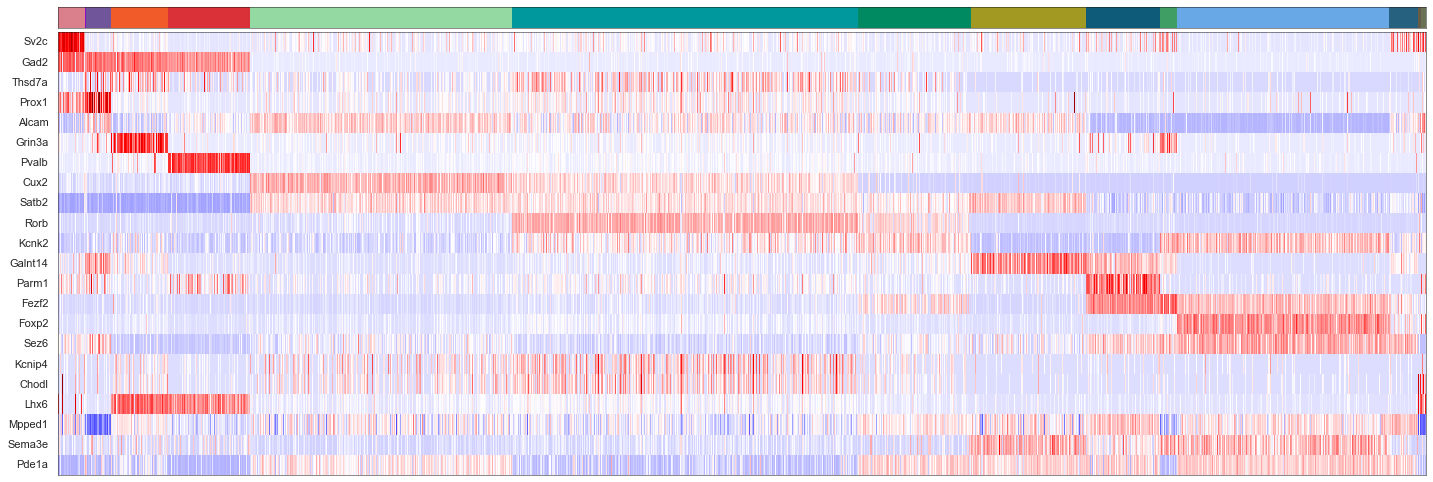

In [76]:
cols = [cell_class_colors[ct] for ct in uniq_celltypes_nwcs]
plot_heatmap(sorted_cbg[:, ::-1], sorted_genes[::-1], calls_nwcs, uniq_celltypes_nwcs, cols, [20, 6.5], vmin=-10, vmax=10).savefig("msmfish_heatmap_nwcs.pdf")

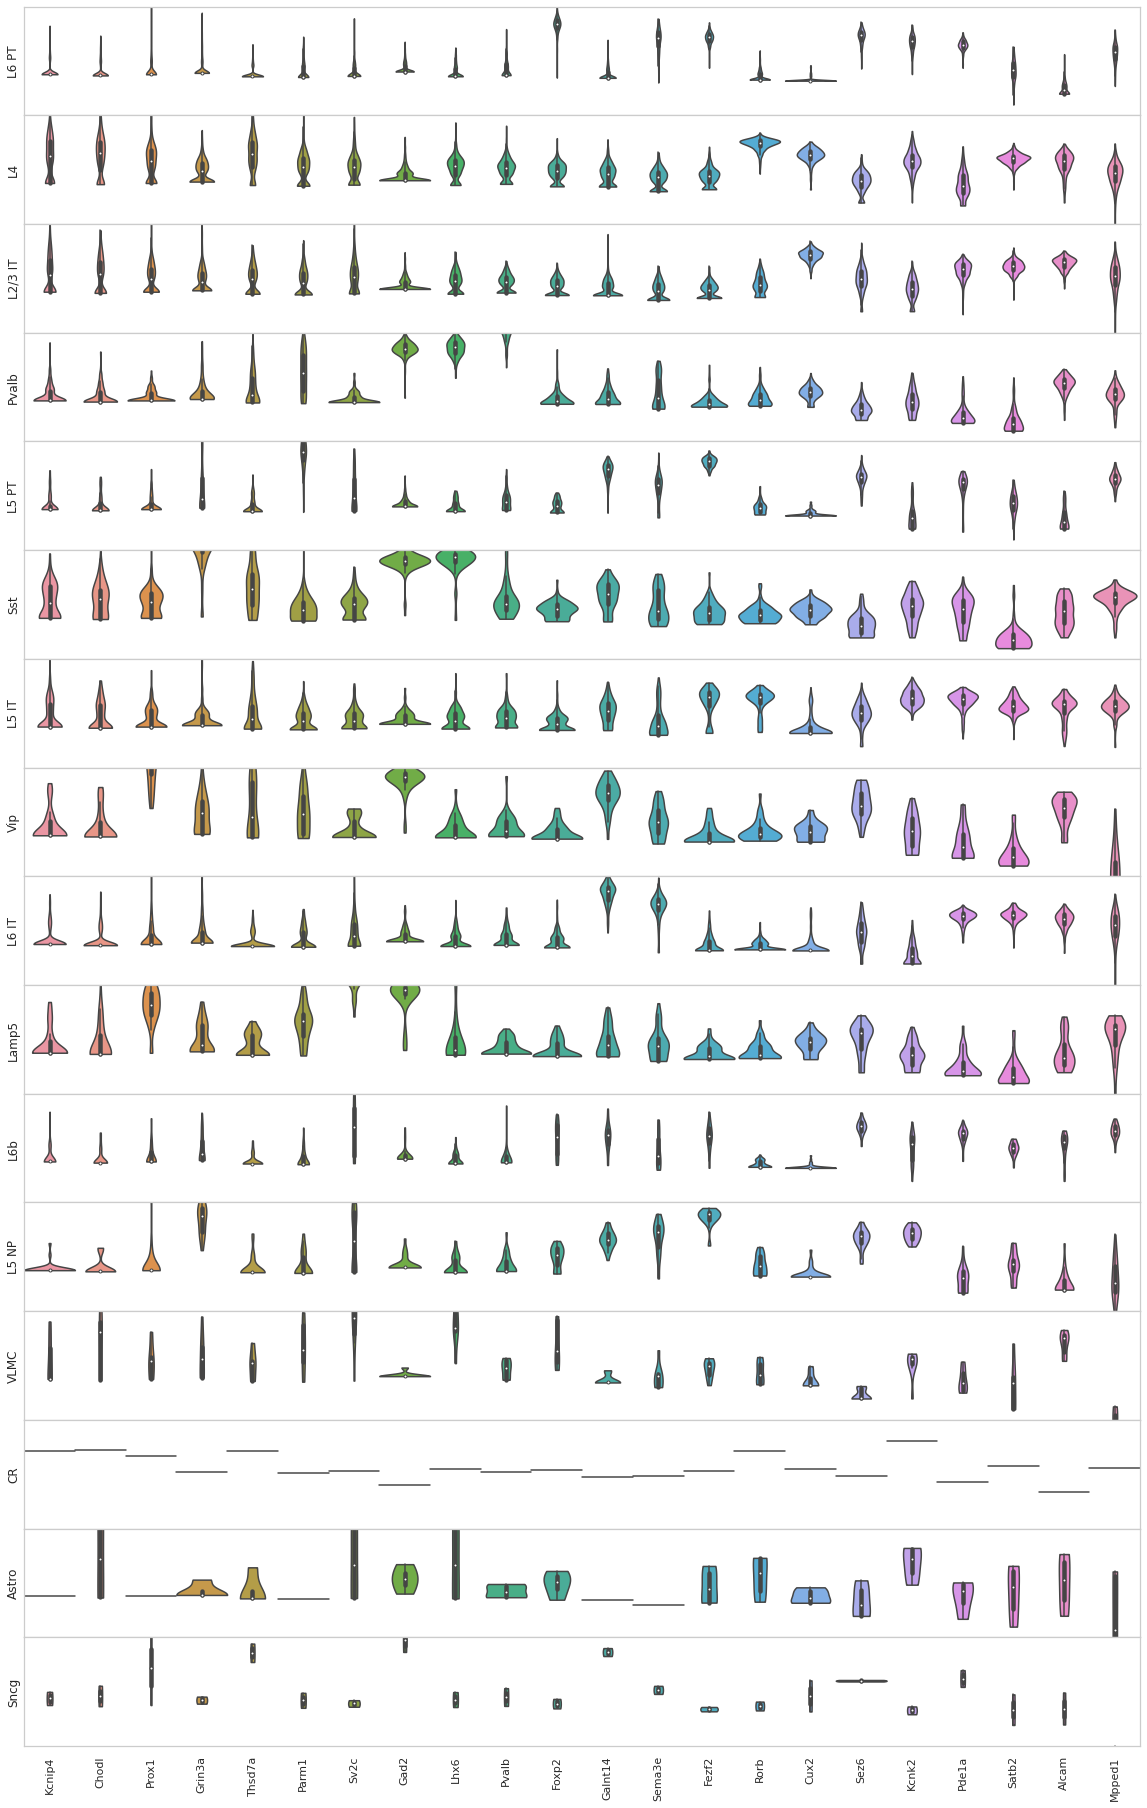

In [47]:
from sklearn import preprocessing
fig, axes = plt.subplots(len(uniq_celltypes_nwcs), 1, figsize=[20, len(uniq_celltypes_nwcs)*2])
plt.subplots_adjust(hspace=0)
for idx, cell_type in enumerate(uniq_celltypes_nwcs):
    cl_vecs = sorted_cbg[calls_nwcs.subclass == cell_type]
    if len(cl_vecs) == 1:
        cl_vecs = np.array([cl_vecs[0], cl_vecs[0]])
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1, cut=0)
    axes[idx].set_ylabel(cell_type)
    axes[idx].set_yticks([])
    axes[idx].set_ylim([-3, 3])
axes[idx].set_xticklabels(sorted_genes, rotation=90)
pass

In [26]:
analysis.map_celltypes(centroids_nwcs)

Generating cell-type map for centroid #0...
Processing chunk (0/1)...
Generating cell-type map for centroid #1...
Processing chunk (0/1)...
Generating cell-type map for centroid #2...
Processing chunk (0/1)...
Generating cell-type map for centroid #3...
Processing chunk (0/1)...
Generating cell-type map for centroid #4...
Processing chunk (0/1)...
Generating cell-type map for centroid #5...
Processing chunk (0/1)...
Generating cell-type map for centroid #6...
Processing chunk (0/1)...
Generating cell-type map for centroid #7...
Processing chunk (0/1)...
Generating cell-type map for centroid #8...
Processing chunk (0/1)...
Generating cell-type map for centroid #9...
Processing chunk (0/1)...
Generating cell-type map for centroid #10...
Processing chunk (0/1)...
Generating cell-type map for centroid #11...
Processing chunk (0/1)...
Generating cell-type map for centroid #12...
Processing chunk (0/1)...
Generating cell-type map for centroid #13...
Processing chunk (0/1)...
Generating cell-

In [27]:
analysis.filter_celltypemaps(min_norm=0.4, min_r=0.6)

In [28]:
map_colors_nwcs = [cell_class_colors[ct] for ct in uniq_celltypes_nwcs]

Text(0.5, 1.0, 'Multiplexed smFISH - NWCS (SSAM)')

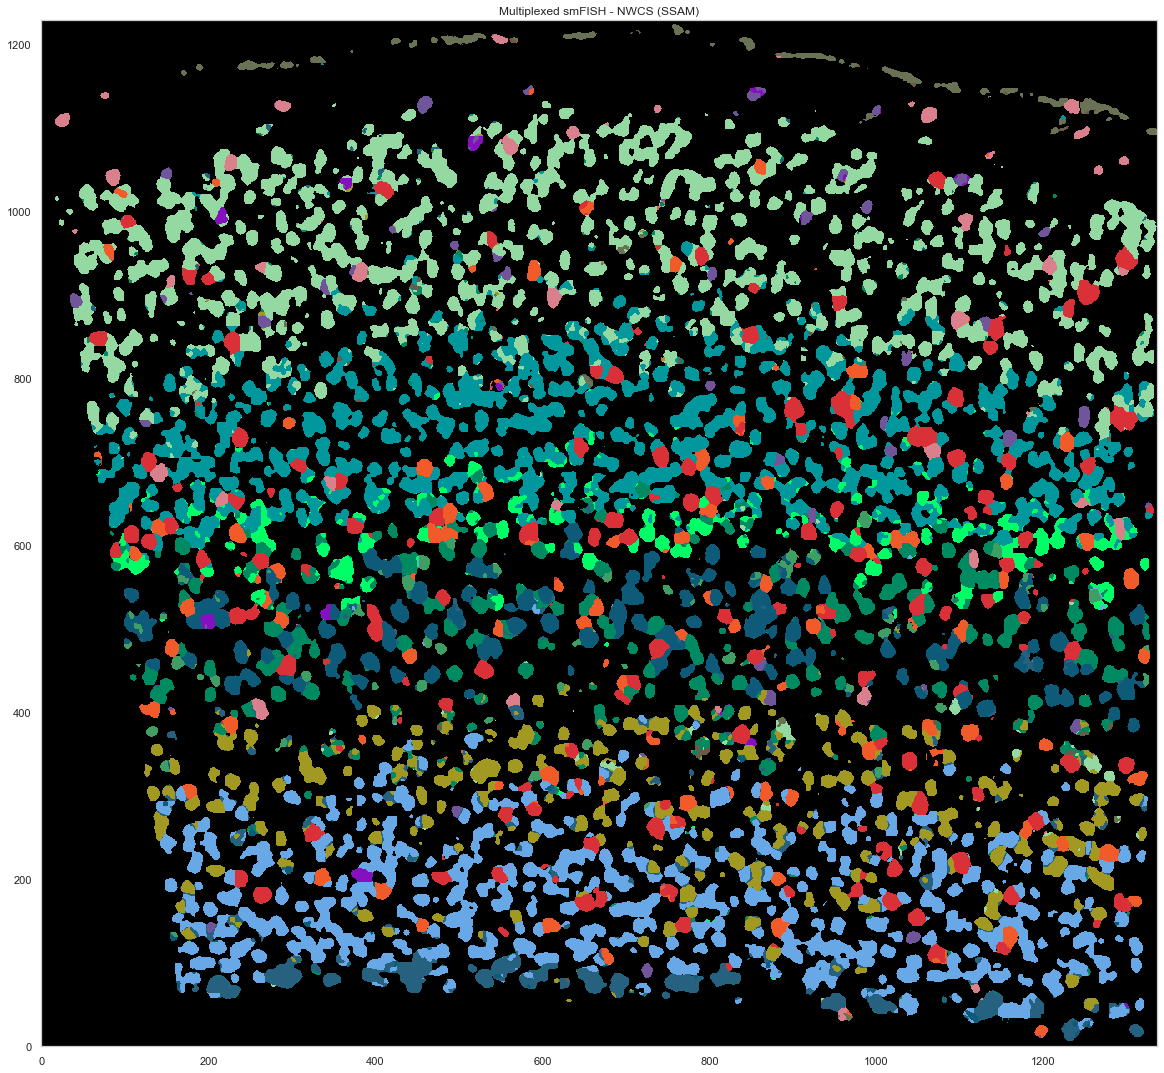

In [29]:
plt.figure(figsize=[20, 20])
ds.plot_celltypes_map(rotate=3, colors=map_colors_nwcs)
plt.title("Multiplexed smFISH - NWCS (SSAM)")

In [30]:
ds.centroids = centroids_nwcs # TODO: this should not be necessary!

In [31]:
analysis.bin_celltypemaps(step=10, radius=100)

In [32]:
analysis.find_domains(n_clusters=20, merge_remote=False, merge_thres=0.8, norm_thres=4000)

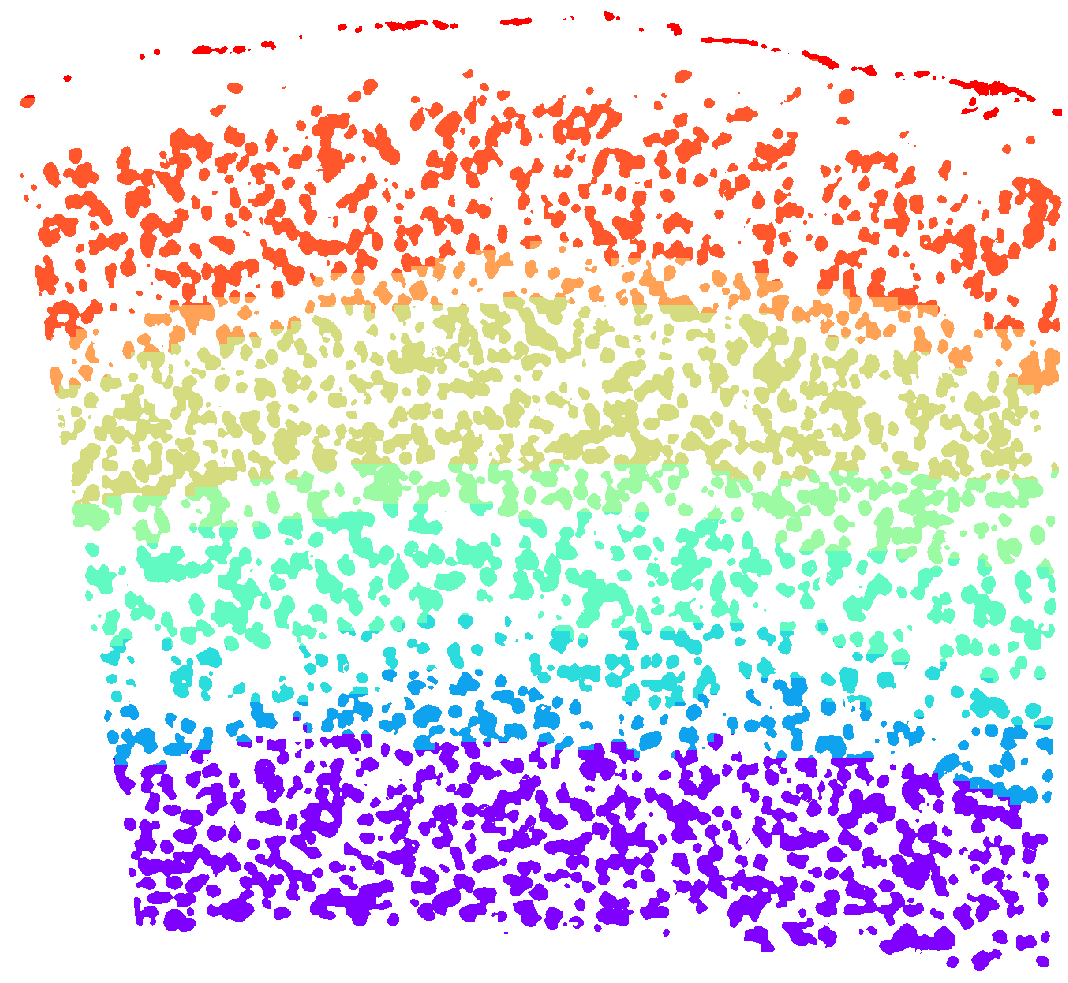

In [33]:
plt.figure(figsize=[15, 15])
ds.plot_domains(rotate=3, cmap='rainbow', z=0)
plt.axis('off')
plt.tight_layout()

In [86]:
layer_annotations = ds.inferred_domains[ds.local_maxs]

AttributeError: 'SSAMDataset' object has no attribute 'inferred_domains'

In [28]:
calls_gmcs = pd.read_csv("consensus_calls/charles/smfish_jeremy_pciseq_renee_eeshit_gabriele_consensus_df.csv")

In [29]:
for cl in calls_gmcs.subclass.unique():
    if cl == "L23_IT":
        calls_gmcs.subclass.loc[calls_gmcs.subclass == "L23_IT"] = "L2/3 IT"
    elif "_" in cl:
        calls_gmcs.subclass.loc[calls_gmcs.subclass == cl] = cl.replace("_", " ")

/tmp/ipykernel_562/1845947111.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_gmcs.subclass.loc[calls_gmcs.subclass == cl] = cl.replace("_", " ")
/tmp/ipykernel_562/1845947111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_gmcs.subclass.loc[calls_gmcs.subclass == "L23_IT"] = "L2/3 IT"


In [30]:
uniq_celltypes_gmcs = [cl for cl in cell_class_colors.keys() if cl in calls_gmcs.subclass.unique()]
centroids_gmcs = []
for cell_type in uniq_celltypes_gmcs:
    centroids_gmcs.append(np.mean(cell_by_gene_normalized[calls_gmcs.subclass == cell_type], axis=0))

In [31]:
centroids_scaled_gmcs = []
for cell_type in uniq_celltypes_gmcs:
    centroids_scaled_gmcs.append(np.mean(cell_by_gene_normalized_scaled[calls_gmcs.subclass == cell_type], axis=0))
    
sorted_cbg, sorted_genes = sort_genes(centroids_scaled_gmcs, cell_by_gene_normalized_scaled, ds.genes)

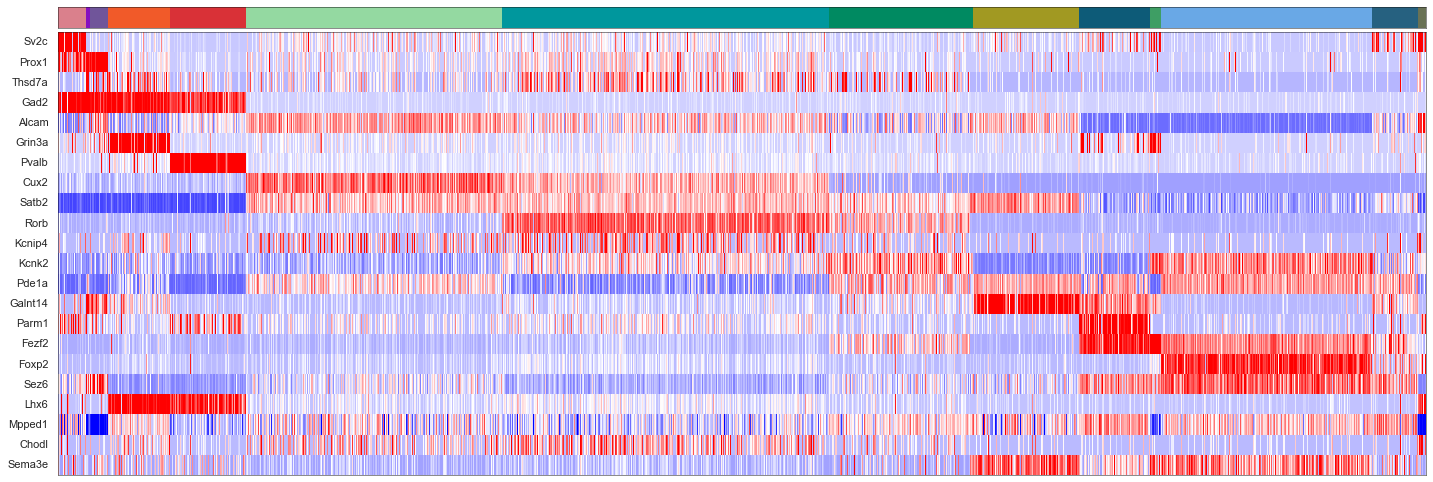

In [32]:
cols = [cell_class_colors[ct] for ct in uniq_celltypes_gmcs]
plot_heatmap(sorted_cbg[:, ::-1], sorted_genes[::-1], calls_gmcs, uniq_celltypes_gmcs, cols, [20, 6.5]).savefig("msmfish_heatmap_gmcs.pdf")

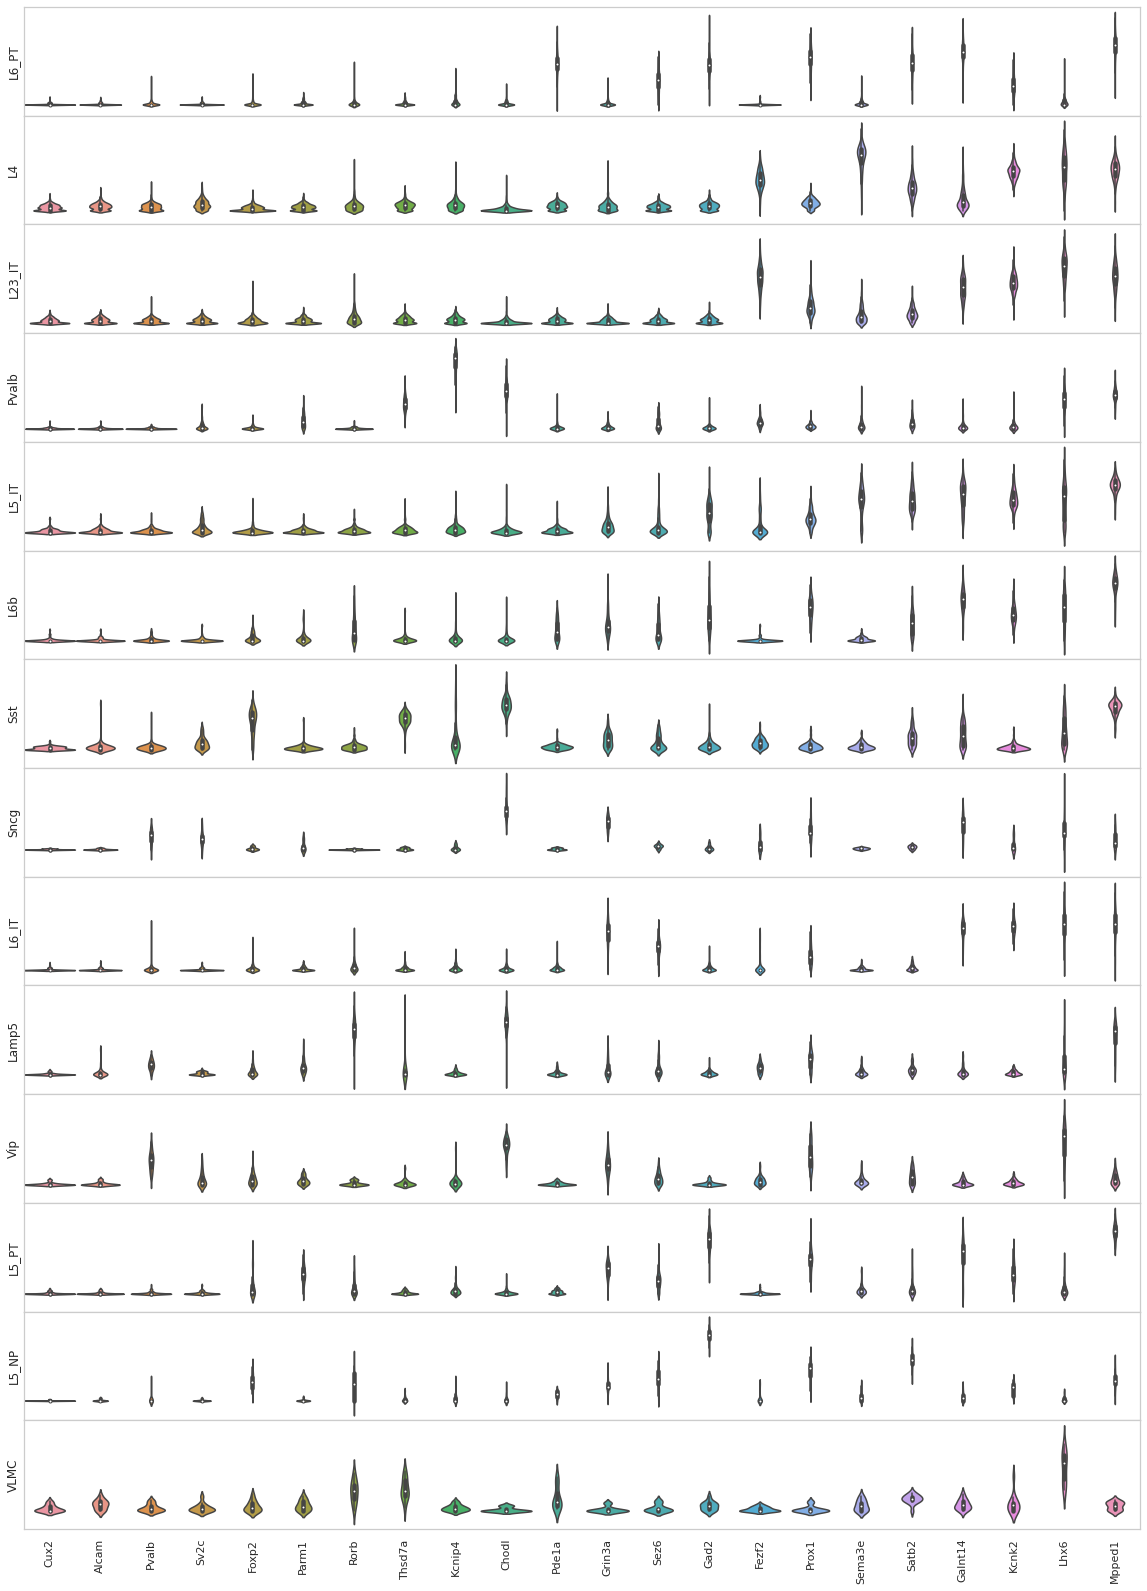

In [56]:
from sklearn import preprocessing
fig, axes = plt.subplots(len(uniq_celltypes_gmcs), 1, figsize=[20, len(uniq_celltypes_gmcs)*2])
plt.subplots_adjust(hspace=0)
for idx, cell_type in enumerate(uniq_celltypes_gmcs):
    cl_vecs = sorted_cbg[calls_gmcs.subclass == cell_type]
    if len(cl_vecs) == 1:
        cl_vecs = np.array([cl_vecs[0], cl_vecs[0]])
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(cell_type)
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(sorted_genes, rotation=90)
pass

In [94]:
analysis.map_celltypes(centroids_gmcs)

Generating cell-type map for centroid #0...
Processing chunk (0/1)...
Generating cell-type map for centroid #1...
Processing chunk (0/1)...
Generating cell-type map for centroid #2...
Processing chunk (0/1)...
Generating cell-type map for centroid #3...
Processing chunk (0/1)...
Generating cell-type map for centroid #4...
Processing chunk (0/1)...
Generating cell-type map for centroid #5...
Processing chunk (0/1)...
Generating cell-type map for centroid #6...
Processing chunk (0/1)...
Generating cell-type map for centroid #7...
Processing chunk (0/1)...
Generating cell-type map for centroid #8...
Processing chunk (0/1)...
Generating cell-type map for centroid #9...
Processing chunk (0/1)...
Generating cell-type map for centroid #10...
Processing chunk (0/1)...
Generating cell-type map for centroid #11...
Processing chunk (0/1)...
Generating cell-type map for centroid #12...
Processing chunk (0/1)...
Generating cell-type map for centroid #13...
Processing chunk (0/1)...


In [98]:
analysis.filter_celltypemaps(min_norm=0.4, min_r=0.6)

In [96]:
map_colors_gmcs = [cell_class_colors[ct.replace("_", " ").replace("L23", "L2/3")] for ct in uniq_celltypes_gmcs]

Text(0.5, 1.0, 'Multiplexed smFISH - GMCS (SSAM)')

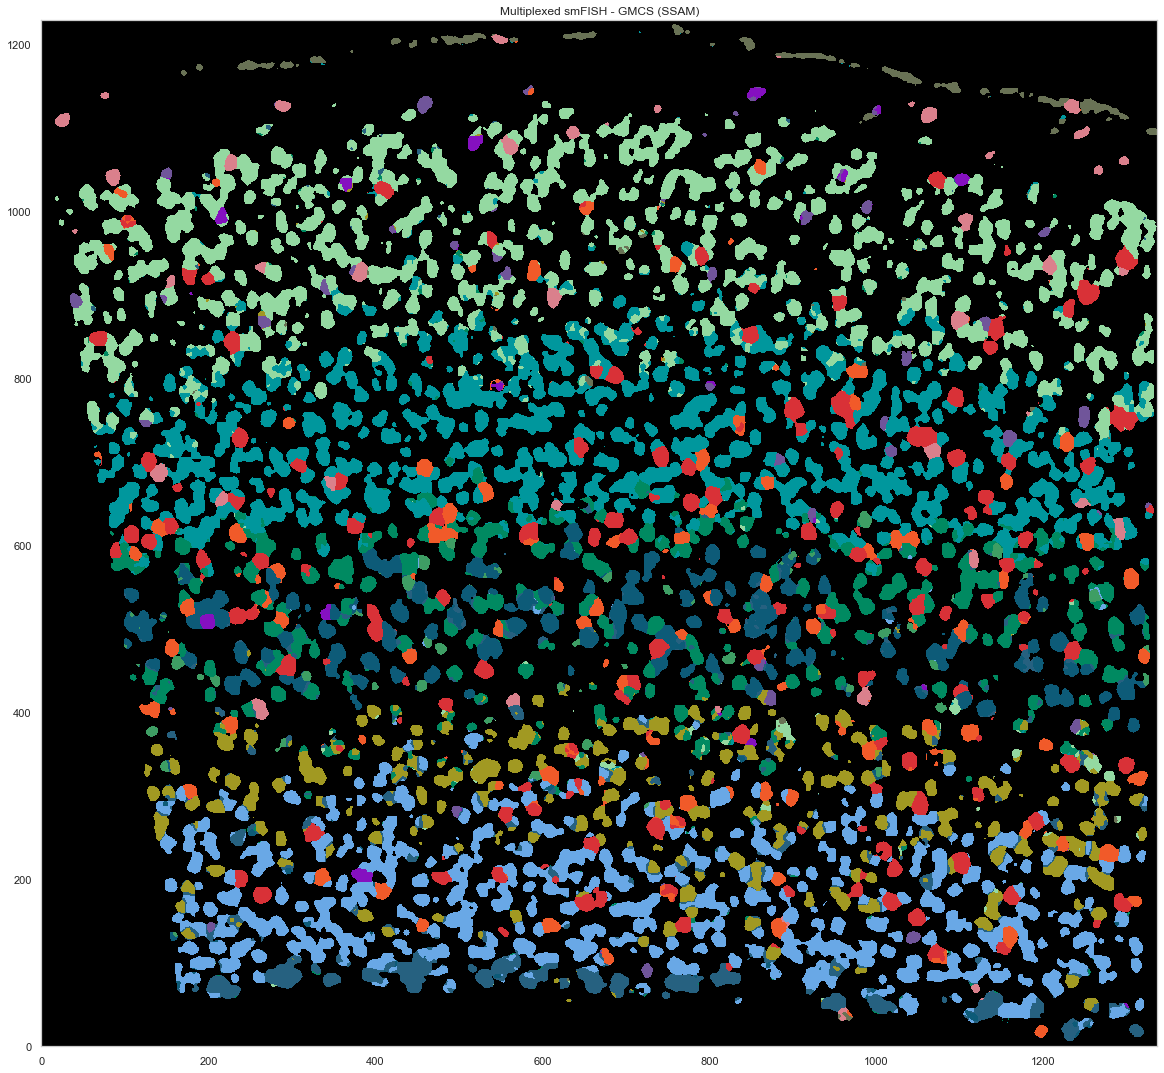

In [269]:
plt.figure(figsize=[20, 20])
ds.plot_celltypes_map(rotate=3, z=0, colors=map_colors_gmcs)
plt.title("Multiplexed smFISH - GMCS (SSAM)")

In [37]:
closest_nwcs_clusters = []
closest_nwcs_clusters_r = []
closest_gmcs_clusters = []
closest_gmcs_clusters_r = []
for v in ds.normalized_vectors:
    corrs = [ssam.utils.corr(v, centroids_nwcs[i]) for i in range(len(centroids_nwcs))]
    idx = np.argmax(corrs)
    closest_nwcs_clusters.append(uniq_celltypes_nwcs[idx])
    closest_nwcs_clusters_r.append(corrs[idx])
    
    corrs = [ssam.utils.corr(v, centroids_gmcs[i]) for i in range(len(centroids_gmcs))]
    idx = np.argmax(corrs)
    closest_gmcs_clusters.append(uniq_celltypes_gmcs[idx])
    closest_gmcs_clusters_r.append(corrs[idx])
    
df = pd.DataFrame(ds.normalized_vectors, columns=ds.genes)
df.to_csv("smfish_ssam_localmax_expression.csv")

df = pd.DataFrame()
df['x'] = ds.local_maxs[0]
df['y'] = ds.local_maxs[1]
df['closest_consensus_nwcs_cluster'] = closest_nwcs_clusters
df['closest_consensus_nwcs_cluster_r'] = closest_nwcs_clusters_r
df['closest_consensus_gmcs_cluster'] = closest_gmcs_clusters
df['closest_consensus_gmcs_cluster_r'] = closest_gmcs_clusters_r
df['layer_annotations_nwcs'] = layer_annotations

df.to_csv("smfish_ssam_localmax_metadata_with_layer.csv")

In [190]:
seg_df

,x,y,gene,molecule_id,prior_segmentation,confidence,cluster,cell,assignment_confidence,is_noise
0,810.126860,9292.386457,Fezf2,1,0,0.00000,4,0,1.0,True
1,1943.257062,9727.200624,Fezf2,2,0,0.00000,4,0,1.0,True
2,2801.555251,12527.203611,Fezf2,3,0,0.99997,1,4516,1.0,False
3,3917.429347,11999.575628,Fezf2,4,3143,1.00000,5,1605,1.0,False
4,2755.021020,13640.961815,Fezf2,5,3246,1.00000,5,4558,1.0,False
...,...,...,...,...,...,...,...,...,...,...
1074773,21673.460029,9583.192477,Parm1,1074774,2095,0.99997,1,481,1.0,False
1074774,22006.806014,9043.561139,Parm1,1074775,2199,0.99997,4,1918,1.0,False
1074775,22638.107108,9538.205623,Parm1,1074776,3299,0.99999,4,3113,1.0,False
1074776,21972.860739,8635.078032,Parm1,1074777,2198,1.00000,1,3924,1.0,False


Text(0.5, 1.0, 'Multiplexed smFISH - NWCS')

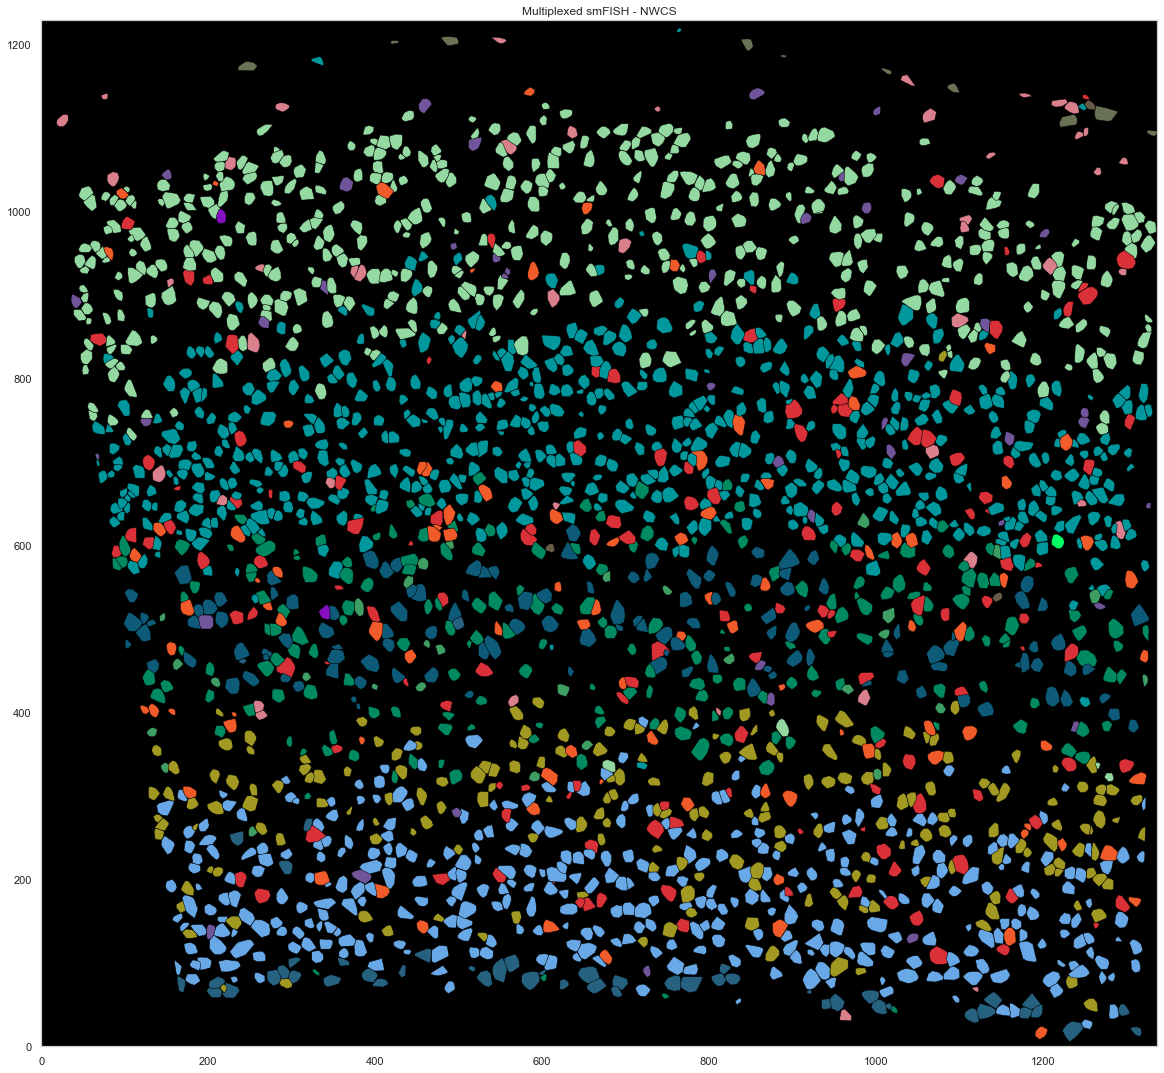

In [267]:
from scipy.spatial import ConvexHull

plt.figure(figsize=[20, 20])
plt.gca().set_facecolor('black')
good_ids = cell_by_gene.index.astype(int)
i = 0
for cid, sdf in spots.groupby("cell"):
    if cid in good_ids:
        points = sdf.iloc[:, :2].to_numpy()
        hull = ConvexHull(points)
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], cell_class_colors[calls_nwcs.subclass[i]], edgecolor="black", linewidth=0.5)
        i += 1
plt.xlim([0, ds.shape[0]])
plt.ylim([0, ds.shape[1]])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Multiplexed smFISH - NWCS")

Text(0.5, 1.0, 'Multiplexed smFISH - GMCS')

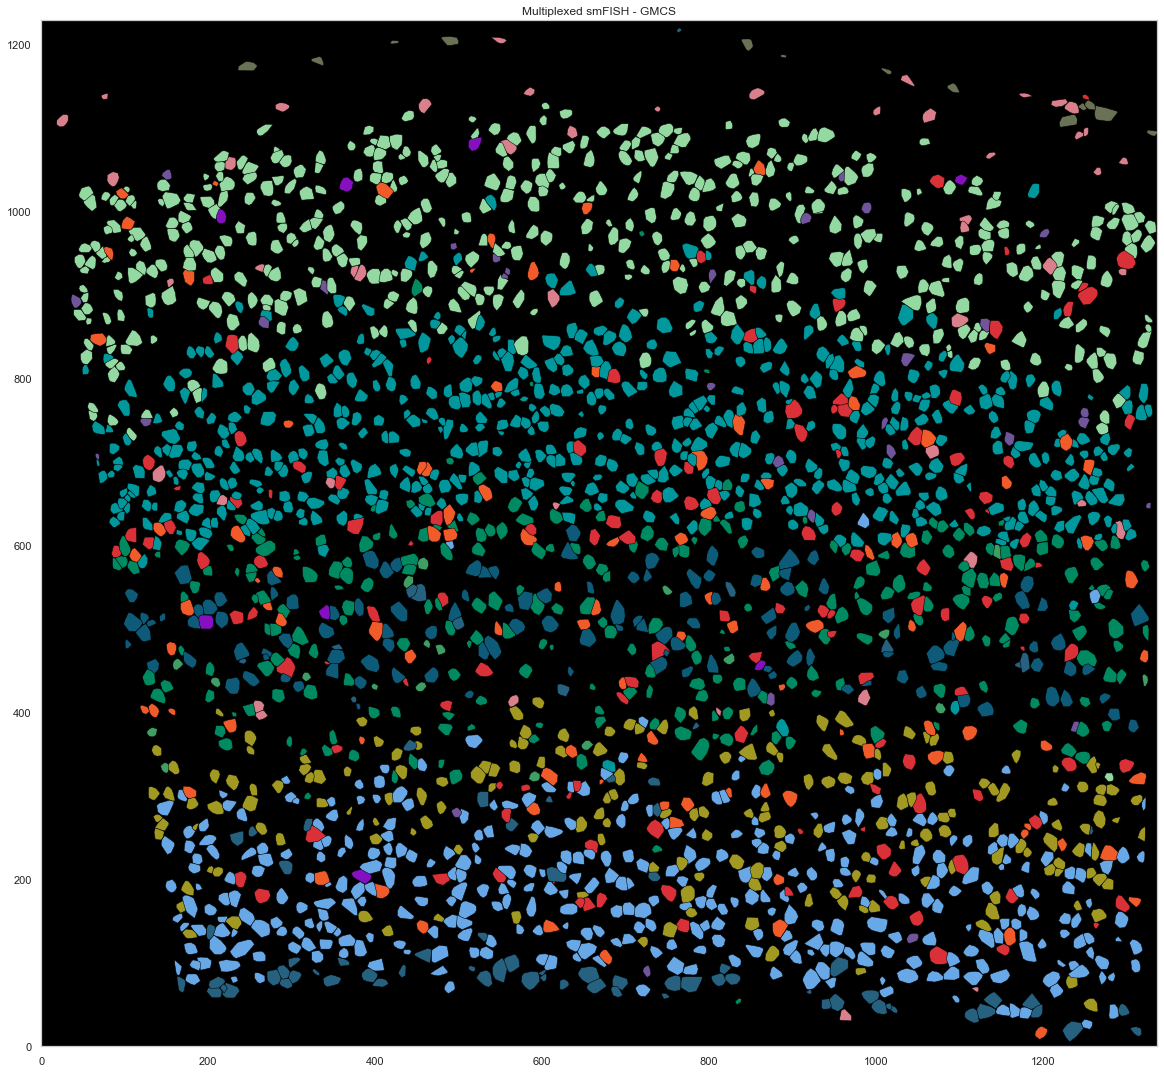

In [268]:
from scipy.spatial import ConvexHull

plt.figure(figsize=[20, 20])
plt.gca().set_facecolor('black')
good_ids = cell_by_gene.index.astype(int)
i = 0
for cid, sdf in spots.groupby("cell"):
    if cid in good_ids:
        points = sdf.iloc[:, :2].to_numpy()
        hull = ConvexHull(points)
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], cell_class_colors[calls_gmcs.subclass[i].replace("_", " ").replace("L23", "L2/3")], edgecolor="black", linewidth=0.5)
        i += 1
plt.xlim([0, ds.shape[0]])
plt.ylim([0, ds.shape[1]])
plt.gca().set_aspect('equal', adjustable='box')

plt.title("Multiplexed smFISH - GMCS")